#  NBA VERİ ANALİZİ 

## Yapılacak Analizler

Mevcut olan verileri birleştirerek ve çeşitli işlemlerden geçirerek iki farklı ana nokta üzerinden analizlerimi gerçekleştirdim:

1) 2014-2021 Yılları arasında oynanmış olan tüm maçların genel analizi

2) Oyundaki detayların oyunu kazanmaya etkisi

BONUS:

Özellikleri belirtildiğinde takımın kazanıp kazanmadığını tahmin edebilecek bir makine öğrenmesi modeli geliştirdim. 

## Veri Seti Hikayesi
Elimizde 5 veri setimiz var: 
* games: Her oyun hakkında bilgiler ve oynayan takımların istatistikleri
* games_details: Bireysel oyuncu istatistikleri hakkında daha ayrıntılı bilgi 
* players: Oyuncunun adı ve takımı hakkında bilgiler 
* ranking: Her takımın sezon boyunca belirli günlerdeki durumu hakkında bilgi 
* teams: Sahiplik, arena, ne zaman kurulduğu vb. dahil takım hakkında bilgiler

## Veriyi Anlama ve Hazırlama


In [1]:
# Gerekli import işlemlerini gerçekleştirdim. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import  StandardScaler
import warnings
warnings.simplefilter(action="ignore")


In [2]:
#Gerekli ayarlamaları yaptım ve veri setlerini okuttum.

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


teams = pd.read_csv("/content/teams.csv")
players = pd.read_csv("/content/players.csv")
ranking = pd.read_csv("/content/ranking.csv")
games = pd.read_csv("/content/games.csv")
details = pd.read_csv("/content/games_details.csv")

In [3]:
# Bir veri setine ilk bakışları fonksiyonel bir şekilde gerçekleştirmeyi sağlayacak bir fonksiyon tanımladım.

def check_df(dataframe, head=5):

    # boyut bilgisi
    print("###################################### Shape ######################################")
    print(dataframe.shape)

    # tip bilgisi
    print("###################################### Types ######################################")
    print(dataframe.dtypes)

    #Baştan gözlemleyelim
    print("###################################### Head ######################################")
    print(dataframe.head(head))

    #Sondan gözlemleyelim
    print("###################################### Tail ######################################")
    print(dataframe.tail(head))

    #Veri setinde herhangi bir eksik değer var mı bakalım
    print("###################################### NA ######################################")
    print(dataframe.isnull().sum())

Veri setinde farklı tipte değişkenler olabilir.

* Sayısal değişkenler
* Katagorik değişkenler
* Sayısal görünümlü ama katagorik olan değişkenler (kazanma-1 kazanamama-0 gibi)
* Katagorik görünümlü olup bilgi taşımayan, ölçüm değeri olmayan değişkenler


In [4]:
# veri seti içerisindeki değişkenin tipini belirleyecek bir fonksiyon tanımladım.

# Bu fonksiyon sayesinde artık veri setindeki değişkenlere göz atabilir ve değişken analizini gerçekleştirebiliriz.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

# **VERİ SETLERİNE GÖZ ATALIM**

# teams

In [5]:
check_df(teams)

###################################### Shape ######################################
(30, 14)
###################################### Types ######################################
LEAGUE_ID               int64
TEAM_ID                 int64
MIN_YEAR                int64
MAX_YEAR                int64
ABBREVIATION           object
NICKNAME               object
YEARFOUNDED             int64
CITY                   object
ARENA                  object
ARENACAPACITY         float64
OWNER                  object
GENERALMANAGER         object
HEADCOACH              object
DLEAGUEAFFILIATION     object
dtype: object
###################################### Head ######################################
   LEAGUE_ID     TEAM_ID  MIN_YEAR  MAX_YEAR ABBREVIATION   NICKNAME  \
0          0  1610612737      1949      2019          ATL      Hawks   
1          0  1610612738      1946      2019          BOS    Celtics   
2          0  1610612740      2002      2019          NOP   Pelicans   
3          0  1610

In [6]:
grab_col_names(teams)

Observations: 30
Variables: 14
cat_cols: 2
num_cols: 4
cat_but_car: 8


(['LEAGUE_ID', 'MAX_YEAR'],
 ['TEAM_ID', 'MIN_YEAR', 'YEARFOUNDED', 'ARENACAPACITY'],
 ['ABBREVIATION',
  'NICKNAME',
  'CITY',
  'ARENA',
  'OWNER',
  'GENERALMANAGER',
  'HEADCOACH',
  'DLEAGUEAFFILIATION'])

Yalnızca ihtiyacım olan sütunların olacağı yeni bir veri kümesi (takımlar) oluşturdum.

In [7]:
takımlar = teams[["TEAM_ID","ABBREVIATION","NICKNAME","CITY"]]

takımlar.rename(columns={"TEAM_ID":"TAKIM_ID",
                        "ABBREVIATION":"TAKIM_KISA",
                        "NICKNAME":"TAKMA_AD",
                        "CITY":"TAKIMIN_SEHRI"},inplace=True)

takımlar.head()

,TAKIM_ID,TAKIM_KISA,TAKMA_AD,TAKIMIN_SEHRI
0,1610612737,ATL,Hawks,Atlanta
1,1610612738,BOS,Celtics,Boston
2,1610612740,NOP,Pelicans,New Orleans
3,1610612741,CHI,Bulls,Chicago
4,1610612742,DAL,Mavericks,Dallas


# games 

In [8]:
check_df(games)

###################################### Shape ######################################
(25796, 21)
###################################### Types ######################################
GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object
###################################### Head ######################################
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-03-12  22101005            Final    1610612748  

In [9]:
grab_col_names(games)

Observations: 25796
Variables: 21
cat_cols: 2
num_cols: 18
cat_but_car: 1


(['GAME_STATUS_TEXT', 'HOME_TEAM_WINS'],
 ['GAME_ID',
  'HOME_TEAM_ID',
  'VISITOR_TEAM_ID',
  'SEASON',
  'TEAM_ID_home',
  'PTS_home',
  'FG_PCT_home',
  'FT_PCT_home',
  'FG3_PCT_home',
  'AST_home',
  'REB_home',
  'TEAM_ID_away',
  'PTS_away',
  'FG_PCT_away',
  'FT_PCT_away',
  'FG3_PCT_away',
  'AST_away',
  'REB_away'],
 ['GAME_DATE_EST'])

In [10]:
#Çoklama durumundaki verileri ve eksik verileri sildim. (veri seti büyük olduğu için bu yöntemi tercih ettim.)

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] 
games.dropna(inplace=True)

Yalnızca ihtiyacım olan sütunların olacağı yeni bir veri kümesi (oyun) oluşturdum.

In [11]:
oyun = games[["GAME_DATE_EST","GAME_ID", "HOME_TEAM_ID","VISITOR_TEAM_ID","SEASON","PTS_home","PTS_away","HOME_TEAM_WINS"]]



oyun.rename(columns={"GAME_DATE_EST":"TARIH",
                        "GAME_ID":"MAC_ID",
                        "HOME_TEAM_ID":"EV_SAHIBI_TAKIM",
                        "VISITOR_TEAM_ID":"DEPLASMAN_TAKIM",
                        "SEASON":"SEZON",
                        "PTS_home":"EV_SAHIBI_PUAN",
                        "PTS_away":"DEPLASMAN_PUAN",
                        "HOME_TEAM_WINS":"EV_SAHIBI_KAZANDI"},inplace=True)

oyun.head()

,TARIH,MAC_ID,EV_SAHIBI_TAKIM,DEPLASMAN_TAKIM,SEZON,EV_SAHIBI_PUAN,DEPLASMAN_PUAN,EV_SAHIBI_KAZANDI
0,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0
1,2022-03-12,22101006,1610612741,1610612739,2021,101.000,91.000,1
2,2022-03-12,22101007,1610612759,1610612754,2021,108.000,119.000,0
3,2022-03-12,22101008,1610612744,1610612749,2021,122.000,109.000,1
4,2022-03-12,22101009,1610612743,1610612761,2021,115.000,127.000,0


# details

In [12]:
check_df(details)

###################################### Shape ######################################
(645953, 29)
###################################### Types ######################################
GAME_ID                int64
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_CITY             object
PLAYER_ID              int64
PLAYER_NAME           object
NICKNAME              object
START_POSITION        object
COMMENT               object
MIN                   object
FGM                  float64
FGA                  float64
FG_PCT               float64
FG3M                 float64
FG3A                 float64
FG3_PCT              float64
FTM                  float64
FTA                  float64
FT_PCT               float64
OREB                 float64
DREB                 float64
REB                  float64
AST                  float64
STL                  float64
BLK                  float64
TO                   float64
PF                   float64
PTS                  float64
PLUS_MI

In [13]:
grab_col_names(details)

Observations: 645953
Variables: 29
cat_cols: 2
num_cols: 21
cat_but_car: 6


(['START_POSITION', 'PF'],
 ['GAME_ID',
  'TEAM_ID',
  'PLAYER_ID',
  'FGM',
  'FGA',
  'FG_PCT',
  'FG3M',
  'FG3A',
  'FG3_PCT',
  'FTM',
  'FTA',
  'FT_PCT',
  'OREB',
  'DREB',
  'REB',
  'AST',
  'STL',
  'BLK',
  'TO',
  'PTS',
  'PLUS_MINUS'],
 ['TEAM_ABBREVIATION',
  'TEAM_CITY',
  'PLAYER_NAME',
  'NICKNAME',
  'COMMENT',
  'MIN'])

In [14]:
details = details.drop_duplicates(subset=["GAME_ID", "PLAYER_NAME"])

In [15]:
detaylar = details[["GAME_ID","TEAM_ID","TEAM_CITY","PLAYER_ID","PLAYER_NAME","FGM","FGA", "FG3M", "FG3A","FTM", "FTA","OREB", "DREB", "REB"]]

detaylar.rename(columns={"GAME_ID":"MAC_ID",
                        "TEAM_ID":"TAKIM_ID",
                        "TEAM_CITY":"SEHIR",
                        "PLAYER_ID":"OYUNCU_ID",
                        "PLAYER_NAME":"OYUNCU_ADI",
                        "FGM":"Saha_Golleri",
                        "FGA":"Denenen_Saha_Hedefleri",
                        "FG3M":"Ucluk_Yapıldı",
                        "FG3A":"Ucluk_Denemesi",
                        "FTM": "Serbest_Atış_Yapıldı",
                        "FTA": "Serbest_Atış_Denendi",
                        "OREB": "Hücum_Ribaundları",
                        "DREB": "Savunma_Ribaundları",
                        "REB":"Toplam_Ribaund"},inplace=True)


detaylar.dropna(inplace=True)
detaylar.head()

,MAC_ID,TAKIM_ID,SEHIR,OYUNCU_ID,OYUNCU_ADI,Saha_Golleri,Denenen_Saha_Hedefleri,Ucluk_Yapıldı,Ucluk_Denemesi,Serbest_Atış_Yapıldı,Serbest_Atış_Denendi,Hücum_Ribaundları,Savunma_Ribaundları,Toplam_Ribaund
0,22101005,1610612750,Minnesota,1630162,Anthony Edwards,4.000,10.000,3.000,8.000,4.000,4.000,0.000,8.000,8.000
1,22101005,1610612750,Minnesota,1630183,Jaden McDaniels,6.000,8.000,1.000,3.000,1.000,1.000,2.000,4.000,6.000
2,22101005,1610612750,Minnesota,1626157,Karl-Anthony Towns,4.000,9.000,1.000,3.000,6.000,8.000,1.000,9.000,10.000
3,22101005,1610612750,Minnesota,1627736,Malik Beasley,4.000,9.000,4.000,9.000,0.000,0.000,0.000,3.000,3.000
4,22101005,1610612750,Minnesota,1626156,D'Angelo Russell,3.000,13.000,1.000,6.000,7.000,7.000,0.000,6.000,6.000


In [16]:
#Detaylar veri setinden, takımların toplam skorlarını gösterecek bir veri seti çıkardım.

detaylar_toplam = detaylar.groupby("TAKIM_ID").agg({"Saha_Golleri": "sum",
                                            "Denenen_Saha_Hedefleri":"sum",
                                            "Ucluk_Yapıldı": "sum",
                                            "Ucluk_Denemesi": "sum",
                                            "Serbest_Atış_Yapıldı": "sum",
                                            "Serbest_Atış_Denendi": "sum",
                                            "Hücum_Ribaundları": "sum",
                                            "Savunma_Ribaundları" : "sum",
                                            "Toplam_Ribaund": "sum"})
detaylar_toplam.reset_index
detaylar_toplam.head()


,Saha_Golleri,Denenen_Saha_Hedefleri,Ucluk_Yapıldı,Ucluk_Denemesi,Serbest_Atış_Yapıldı,Serbest_Atış_Denendi,Hücum_Ribaundları,Savunma_Ribaundları,Toplam_Ribaund
TAKIM_ID,,,,,,,,,
1610612737,64034.000,141666.000,13965.000,39490.000,30761.000,40359.000,18057.000,53954.000,72011.000
1610612738,67454.000,147513.000,14807.000,41613.000,32917.000,42642.000,17959.000,57716.000,75675.000
1610612739,65001.000,144337.000,14324.000,40159.000,31717.000,42649.000,19694.000,55775.000,75469.000
1610612740,62550.000,138046.000,12539.000,35438.000,28985.000,38091.000,18120.000,52653.000,70773.000
1610612741,63603.000,142888.000,12604.000,35196.000,29945.000,39314.000,19457.000,55829.000,75286.000


# players

In [17]:
check_df(players)

###################################### Shape ######################################
(7228, 4)
###################################### Types ######################################
PLAYER_NAME    object
TEAM_ID         int64
PLAYER_ID       int64
SEASON          int64
dtype: object
###################################### Head ######################################
        PLAYER_NAME     TEAM_ID  PLAYER_ID  SEASON
0     Royce O'Neale  1610612762    1626220    2019
1  Bojan Bogdanovic  1610612762     202711    2019
2       Rudy Gobert  1610612762     203497    2019
3  Donovan Mitchell  1610612762    1628378    2019
4       Mike Conley  1610612762     201144    2019
###################################### Tail ######################################
          PLAYER_NAME     TEAM_ID  PLAYER_ID  SEASON
7223      Lanny Smith  1610612758     201831    2009
7224    Warren Carter  1610612752     201999    2009
7225     Bennet Davis  1610612751     201834    2009
7226   Brian Hamilton  1610612751   

In [18]:
grab_col_names(players)

Observations: 7228
Variables: 4
cat_cols: 0
num_cols: 3
cat_but_car: 1


([], ['TEAM_ID', 'PLAYER_ID', 'SEASON'], ['PLAYER_NAME'])

In [19]:
# kaç oyuncu var?
players["PLAYER_ID"].nunique()

1769

In [20]:
#oyuncu farklı sezonlarda farklı takımlarda oynamış olabilir, oyuncu ıd lere göre çoklamaları sildim.
oyuncular = players.drop_duplicates(subset=["PLAYER_ID"])

# ihtiyacım olabilecek bir veri seti çıkardım.
oyuncular = players[["PLAYER_NAME","PLAYER_ID"]]

oyuncular.rename(columns={"PLAYER_NAME":"OYUNCU",
                        "PLAYER_ID":"OYUNCU_ID"},inplace=True)

oyuncular.head()

,OYUNCU,OYUNCU_ID
0,Royce O'Neale,1626220
1,Bojan Bogdanovic,202711
2,Rudy Gobert,203497
3,Donovan Mitchell,1628378
4,Mike Conley,201144


#ranking

In [21]:
check_df(ranking)

###################################### Shape ######################################
(201792, 13)
###################################### Types ######################################
TEAM_ID            int64
LEAGUE_ID          int64
SEASON_ID          int64
STANDINGSDATE     object
CONFERENCE        object
TEAM              object
G                  int64
W                  int64
L                  int64
W_PCT            float64
HOME_RECORD       object
ROAD_RECORD       object
RETURNTOPLAY     float64
dtype: object
###################################### Head ######################################
      TEAM_ID  LEAGUE_ID  SEASON_ID STANDINGSDATE CONFERENCE          TEAM  \
0  1610612756          0      22021    2022-03-12       West       Phoenix   
1  1610612744          0      22021    2022-03-12       West  Golden State   
2  1610612763          0      22021    2022-03-12       West       Memphis   
3  1610612762          0      22021    2022-03-12       West          Utah   
4  1610

In [22]:
grab_col_names(ranking)

Observations: 201792
Variables: 13
cat_cols: 3
num_cols: 6
cat_but_car: 4


(['CONFERENCE', 'LEAGUE_ID', 'RETURNTOPLAY'],
 ['TEAM_ID', 'SEASON_ID', 'G', 'W', 'L', 'W_PCT'],
 ['STANDINGSDATE', 'TEAM', 'HOME_RECORD', 'ROAD_RECORD'])

In [23]:
sıralama = ranking[["TEAM_ID","SEASON_ID","TEAM","G","W","L", "W_PCT"]]

sıralama.rename(columns={"TEAM_ID":"TAKIM_ID",
                        "SEASON_ID":"SEZON_ID",
                        "TEAM":"TAKIM",
                        "G":"TOPLAM_MAC",
                        "W":"KAZANILAN_MAC",
                        "L":"KAYBEDİLEN_MAC",
                        "W_PCT":"KAZANMA_ORANI"},inplace=True)


sıralama.head()

,TAKIM_ID,SEZON_ID,TAKIM,TOPLAM_MAC,KAZANILAN_MAC,KAYBEDİLEN_MAC,KAZANMA_ORANI
0,1610612756,22021,Phoenix,67,53,14,0.791
1,1610612744,22021,Golden State,68,46,22,0.676
2,1610612763,22021,Memphis,68,46,22,0.676
3,1610612762,22021,Utah,67,42,25,0.627
4,1610612742,22021,Dallas,67,41,26,0.612


In [24]:
#sıralama veri setinden tüm sezonların toplamlarını verecek şekilde bir bilgi içeren veri seti oluşturdum.

sıralama_toplam = sıralama.groupby("TAKIM_ID").agg({"TOPLAM_MAC": "sum",
                                            "KAZANILAN_MAC":"sum",
                                            "KAYBEDİLEN_MAC": "sum"})
sıralama_toplam.reset_index
sıralama_toplam.head()


,TOPLAM_MAC,KAZANILAN_MAC,KAYBEDİLEN_MAC
TAKIM_ID,,,
1610612737,380105,175413,204692
1610612738,380493,215461,165032
1610612739,379739,188621,191118
1610612740,380519,174278,206241
1610612741,379292,188037,191255


## **ANALİZ VERİ SETLERİ**

# 1) toplam_veri

2014-2021 Yılları arasında oynanmış olan tüm maçların genel analizi için kullandım

# 2) oyun_veri

Oyundaki detayların oyunu kazanmaya etkisini incelemek için kullandım

#  1) toplam_veri

* Takımların 2014-2022 sezonları arasında oynamış olduğu maçlar hakkında bilgi içeren sıralama_toplam veri seti ile 2014-2022 sezonları arasında oynanan maçlardaki toplam deneme ve skorları içeren detaylar_toplam veri setlerini birleştirdim.


In [25]:
toplam_veri= pd.merge(sıralama_toplam, detaylar_toplam, on='TAKIM_ID')

#float gibi gözüken ama int olan verilerin tipini değiştirdim. 
toplam_veri = toplam_veri.astype(int)

# oluşturduğum toplam_veri setini takımlar veri setiyle birleştirerek takım bilgilerini de ekledim.
toplam_veri = pd.merge(takımlar, toplam_veri, on='TAKIM_ID')
toplam_veri.head()

# çeşitli oranları hesaplayarak veri setine yeni değişkenler olarak ekledim.

toplam_veri['Kazanma_Oranı'] = toplam_veri['KAZANILAN_MAC'] / toplam_veri['TOPLAM_MAC'] 
toplam_veri['Saha_Gol_Başarı_Oranı'] = toplam_veri['Saha_Golleri'] / toplam_veri['Denenen_Saha_Hedefleri']
toplam_veri['Üçlük_Başarı_Oranı'] = toplam_veri['Ucluk_Yapıldı'] / toplam_veri['Ucluk_Denemesi']
toplam_veri['Serbest_Atış_Başarı_Oranı'] = toplam_veri['Serbest_Atış_Yapıldı'] / toplam_veri['Serbest_Atış_Denendi']
toplam_veri['Hücum_Ribaund_Oranı'] = toplam_veri['Hücum_Ribaundları'] / toplam_veri['Toplam_Ribaund']
toplam_veri['Savunma_Ribaund_Oranı'] = toplam_veri['Savunma_Ribaundları'] / toplam_veri['Toplam_Ribaund']


toplam_veri.head()

,TAKIM_ID,TAKIM_KISA,TAKMA_AD,TAKIMIN_SEHRI,TOPLAM_MAC,KAZANILAN_MAC,KAYBEDİLEN_MAC,Saha_Golleri,Denenen_Saha_Hedefleri,Ucluk_Yapıldı,Ucluk_Denemesi,Serbest_Atış_Yapıldı,Serbest_Atış_Denendi,Hücum_Ribaundları,Savunma_Ribaundları,Toplam_Ribaund,Kazanma_Oranı,Saha_Gol_Başarı_Oranı,Üçlük_Başarı_Oranı,Serbest_Atış_Başarı_Oranı,Hücum_Ribaund_Oranı,Savunma_Ribaund_Oranı
0,1610612737,ATL,Hawks,Atlanta,380105,175413,204692,64034,141666,13965,39490,30761,40359,18057,53954,72011,0.461,0.452,0.354,0.762,0.251,0.749
1,1610612738,BOS,Celtics,Boston,380493,215461,165032,67454,147513,14807,41613,32917,42642,17959,57716,75675,0.566,0.457,0.356,0.772,0.237,0.763
2,1610612740,NOP,Pelicans,New Orleans,380519,174278,206241,62550,138046,12539,35438,28985,38091,18120,52653,70773,0.458,0.453,0.354,0.761,0.256,0.744
3,1610612741,CHI,Bulls,Chicago,379292,188037,191255,63603,142888,12604,35196,29945,39314,19457,55829,75286,0.496,0.445,0.358,0.762,0.258,0.742
4,1610612742,DAL,Mavericks,Dallas,382050,224017,158033,66360,145449,15212,42708,31849,40673,18289,56339,74628,0.586,0.456,0.356,0.783,0.245,0.755


# 2) oyun_veri

Oyundaki detayların oyunu kazanmaya etkisini incelemek için kullandım


In [26]:
# Birleştireceğim veri setleri içinden ilgili kolonları seçtim.

d1 = detaylar[["MAC_ID","OYUNCU_ID","OYUNCU_ADI","Saha_Golleri","Denenen_Saha_Hedefleri", "Ucluk_Yapıldı", "Ucluk_Denemesi","Serbest_Atış_Yapıldı", "Serbest_Atış_Denendi","Hücum_Ribaundları", "Savunma_Ribaundları", "Toplam_Ribaund"]]
d2 = oyun[["MAC_ID", "TARIH", "EV_SAHIBI_TAKIM", "DEPLASMAN_TAKIM"  ]]

#Verileri birleştirdim.
oyun_veri = pd.merge(oyun,detaylar,how='right')

#TAKIM_ID kısmında takımın ID'si yerine takımın ev sahibi mi yoksa deplasman takım mı olduğu bilgisinin olmasını istiyorum. Çünkü veri setinde "EV_SAHIBI_TAKIM", "DEPLASMAN_TAKIM" kolonlarında ıd bilgisi mevcut.
oyun_veri.loc[oyun_veri["TAKIM_ID"] == oyun_veri["EV_SAHIBI_TAKIM"], "TAKIM_ID" ] = "Ev Sahibi Takım"
oyun_veri.loc[oyun_veri["TAKIM_ID"] == oyun_veri["DEPLASMAN_TAKIM"], "TAKIM_ID" ] = "Deplasman Takım"


oyun_veri.rename(columns={'TAKIM_ID':'TAKIM'}, inplace=True)



oyun_veri.head()

,TARIH,MAC_ID,EV_SAHIBI_TAKIM,DEPLASMAN_TAKIM,SEZON,EV_SAHIBI_PUAN,DEPLASMAN_PUAN,EV_SAHIBI_KAZANDI,TAKIM,SEHIR,OYUNCU_ID,OYUNCU_ADI,Saha_Golleri,Denenen_Saha_Hedefleri,Ucluk_Yapıldı,Ucluk_Denemesi,Serbest_Atış_Yapıldı,Serbest_Atış_Denendi,Hücum_Ribaundları,Savunma_Ribaundları,Toplam_Ribaund
0,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0,Deplasman Takım,Minnesota,1630162,Anthony Edwards,4.000,10.000,3.000,8.000,4.000,4.000,0.000,8.000,8.000
1,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0,Deplasman Takım,Minnesota,1630183,Jaden McDaniels,6.000,8.000,1.000,3.000,1.000,1.000,2.000,4.000,6.000
2,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0,Deplasman Takım,Minnesota,1626157,Karl-Anthony Towns,4.000,9.000,1.000,3.000,6.000,8.000,1.000,9.000,10.000
3,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0,Deplasman Takım,Minnesota,1627736,Malik Beasley,4.000,9.000,4.000,9.000,0.000,0.000,0.000,3.000,3.000
4,2022-03-12,22101005,1610612748,1610612750,2021,104.000,113.000,0,Deplasman Takım,Minnesota,1626156,D'Angelo Russell,3.000,13.000,1.000,6.000,7.000,7.000,0.000,6.000,6.000


##⭐ **ANALİZLER** ⭐

In [27]:
#En çok kazanan 3 takım hangileri? 
toplam_veri.sort_values("KAZANILAN_MAC", ascending=False).head(3)


,TAKIM_ID,TAKIM_KISA,TAKMA_AD,TAKIMIN_SEHRI,TOPLAM_MAC,KAZANILAN_MAC,KAYBEDİLEN_MAC,Saha_Golleri,Denenen_Saha_Hedefleri,Ucluk_Yapıldı,Ucluk_Denemesi,Serbest_Atış_Yapıldı,Serbest_Atış_Denendi,Hücum_Ribaundları,Savunma_Ribaundları,Toplam_Ribaund,Kazanma_Oranı,Saha_Gol_Başarı_Oranı,Üçlük_Başarı_Oranı,Serbest_Atış_Başarı_Oranı,Hücum_Ribaund_Oranı,Savunma_Ribaund_Oranı
20,1610612759,SAS,Spurs,San Antonio,380516,255997,124519,69734,149192,14461,38717,31068,40867,18059,59658,77717,0.673,0.467,0.374,0.760,0.232,0.768
4,1610612742,DAL,Mavericks,Dallas,382050,224017,158033,66360,145449,15212,42708,31849,40673,18289,56339,74628,0.586,0.456,0.356,0.783,0.245,0.755
6,1610612745,HOU,Rockets,Houston,381271,221048,160223,64634,143937,17890,50636,32828,43540,18712,56335,75047,0.580,0.449,0.353,0.754,0.249,0.751


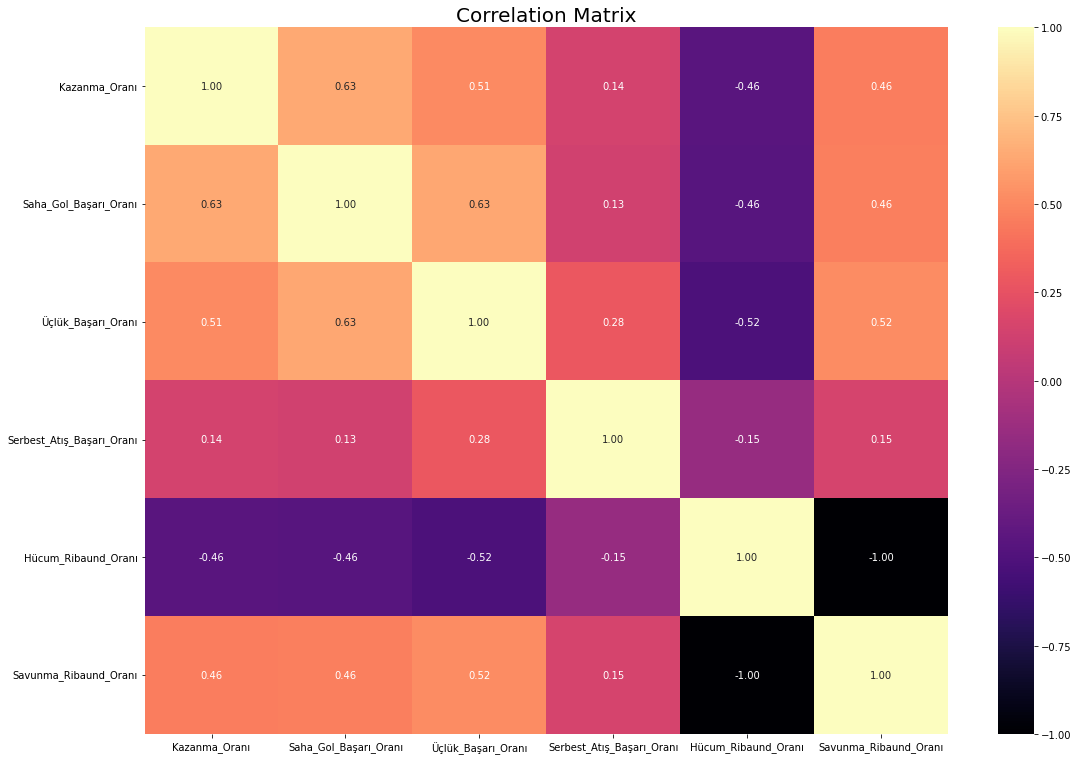

In [28]:
#  Kazanmaya etki eden şeyler neler olabilir?

num_cols1 = ['Kazanma_Oranı', 'Saha_Gol_Başarı_Oranı', 'Üçlük_Başarı_Oranı','Serbest_Atış_Başarı_Oranı', 'Hücum_Ribaund_Oranı','Savunma_Ribaund_Oranı']

toplam_veri[num_cols1].corr()

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(toplam_veri[num_cols1].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

* Kazanma oranı ile , saha gol başarı oranı ve üçlük başarı oranı arasında bir ilişki var gibi gözüküyor.

* gol oranı ile kazanma oranı arasında ilişki olması beklenen bir durum.

* üçlük başarı oranı ile ilgili daha detaylı bir inceleme yapılabilir.


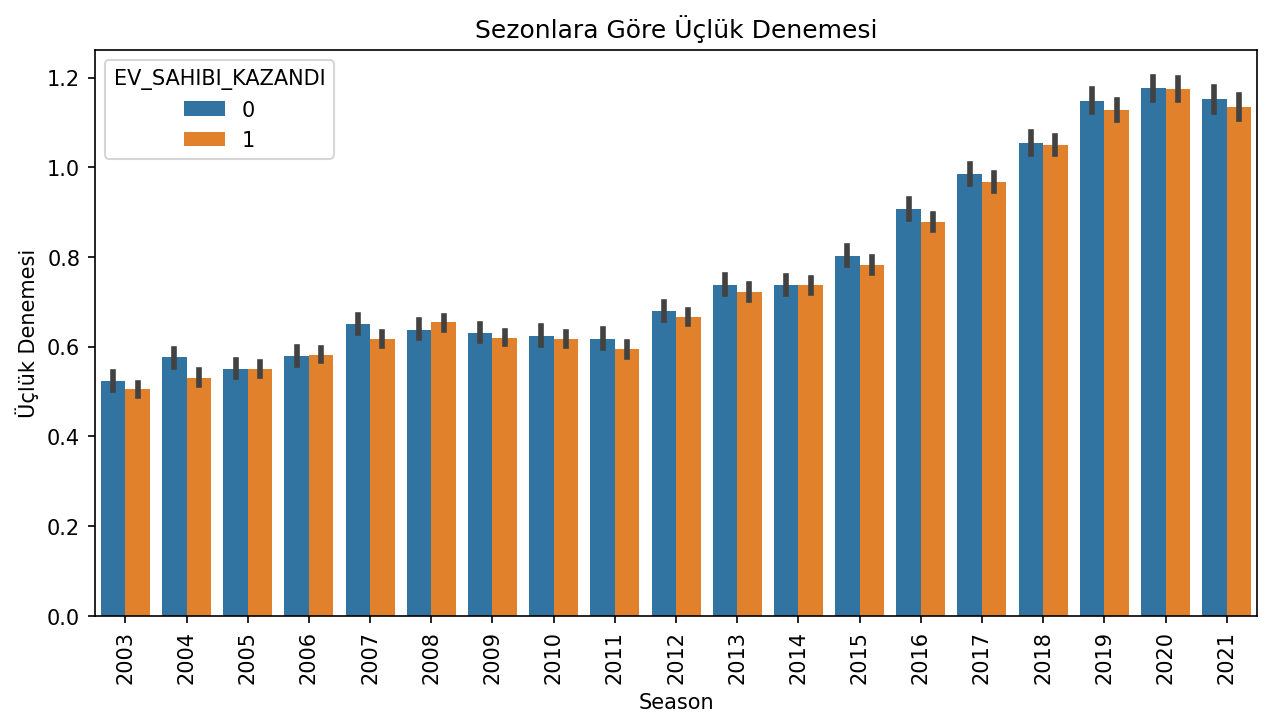

In [29]:
plt.figure(figsize=(10,5),dpi=150)
ax = sns.barplot(data=oyun_veri,x="SEZON",y="Ucluk_Yapıldı",hue="EV_SAHIBI_KAZANDI")

ax.set(ylabel="Üçlük Denemesi", xlabel="Season")
ax.set_title("Sezonlara Göre Üçlük Denemesi")

plt.xticks(rotation=90);

Bakıldığı zaman takımların üçlük deneme sayısının yıllar geçtikçe arttığı söylenebilir. Bu bilgi de üçlük başarısnın kazanmaya etkisi olduğu bulgusunu destekler niteliktedir.

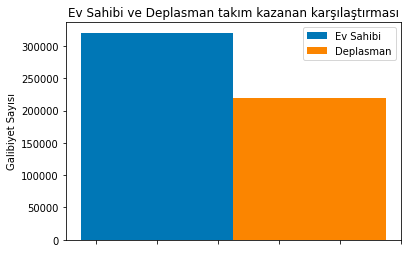

In [30]:
# Takımlar kendi sahasındayken daha iyi performans gösterir mi? 

ev_Sahibi_kazandı = oyun_veri.groupby(['EV_SAHIBI_KAZANDI']).get_group(1)
ev_Sahibi_kaybetti = oyun_veri.groupby(['EV_SAHIBI_KAZANDI']).get_group(0)

x = ev_Sahibi_kazandı['EV_SAHIBI_KAZANDI'].value_counts()
y = ev_Sahibi_kaybetti['EV_SAHIBI_KAZANDI'].value_counts()

ti = [0.5]
hor = np.arange(len(ti))

plt.bar(ti,x,width = 0.25,color = '#0077b6',label = 'Ev Sahibi')
plt.bar(hor + 0.75,y,width = 0.25,color = '#fb8500',label = 'Deplasman')

plt.ylabel('Galibiyet Sayısı')
plt.xticks(color = 'w')
plt.title('Ev Sahibi ve Deplasman takım kazanan karşılaştırması')
plt.legend()


Takımların kendi sahasında daha başarılı olduğu bilgisi çıkarılabilir.

Farklı sezonlarda ev sahibi ve deplasman takım puan istatistiklerine de bir göz atmakta fayda olacaktır.


Maksimum ev sahibi takım puanı 168.0
Minimum ev sahibi takım puanı 36.0
Maksimum deplasman takım puanı 168.0
Minimum deplasman takım puanı 33.0


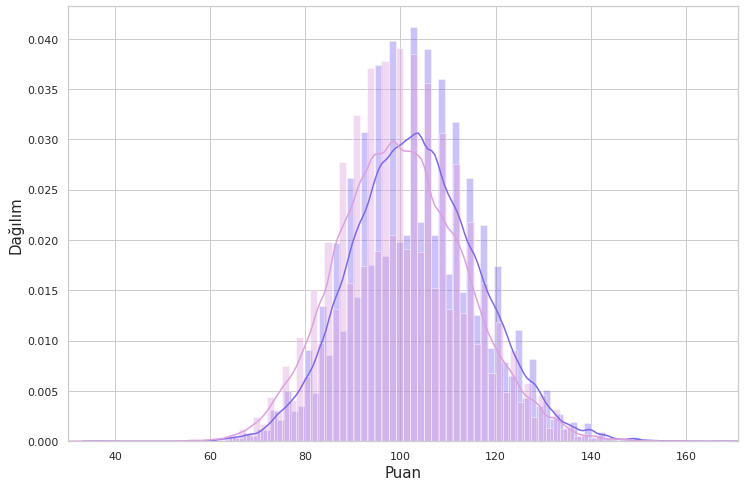

In [31]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(style = 'whitegrid')

sns.distplot(oyun_veri['EV_SAHIBI_PUAN'], bins = 90, color = 'mediumslateblue')
plt.ylabel("Dağılım", fontsize = 15)
plt.xlabel("Puan", fontsize = 15)
plt.margins(x = 0)

print ("Maksimum ev sahibi takım puanı", oyun_veri['EV_SAHIBI_PUAN'].max())
print ("Minimum ev sahibi takım puanı", oyun_veri['EV_SAHIBI_PUAN'].min())


plt.rcParams['figure.figsize'] = [12, 8]
sns.set(style = 'whitegrid')

sns.distplot(oyun_veri['DEPLASMAN_PUAN'], bins = 90, color = "plum")
plt.ylabel("Dağılım", fontsize = 15)
plt.xlabel("Puan", fontsize = 15)
plt.margins(x = 0)

print ("Maksimum deplasman takım puanı", oyun_veri['DEPLASMAN_PUAN'].max())
print ("Minimum deplasman takım puanı", oyun_veri['DEPLASMAN_PUAN'].min())


# BONUS

oyun_veri verisetini kullanarak özellikleri belirtildiğinde takımın kazanıp kazanmadığını tahmin edebilecek bir makine öğrenmesi modeli geliştirmek istiyorum.

In [32]:
oyun_veri.loc[(oyun_veri["TAKIM"] == "Deplasman Takım") & (oyun_veri["EV_SAHIBI_KAZANDI"] != 1), "EV_SAHIBI_KAZANDI" ] = 1
oyun_veri.loc[(oyun_veri["TAKIM"] == "Deplasman Takım") & (oyun_veri["EV_SAHIBI_KAZANDI"] == 1), "EV_SAHIBI_KAZANDI" ] = 0

oyun_veri.rename(columns={'EV_SAHIBI_KAZANDI':'KAZANMA_DURUMU'}, inplace=True)

In [33]:
#veri seti bir oyunda olan her anı içerdiği için oyunları gruplayarak inceleme yapılacak. 
oyun_veri_grup = oyun_veri.groupby(by=["MAC_ID", "TAKIM"]).agg({"KAZANMA_DURUMU": "median",
                                            "Saha_Golleri":"sum",
                                            "Denenen_Saha_Hedefleri": "sum",
                                            "Ucluk_Yapıldı": "sum",
                                            "Ucluk_Denemesi": "sum",
                                            "Serbest_Atış_Yapıldı": "sum",
                                            "Serbest_Atış_Denendi": "sum",
                                            "Hücum_Ribaundları": "sum",
                                            "Savunma_Ribaundları": "sum",
                                            "Toplam_Ribaund": "sum"})


#float gibi gözüken ama int olan verilerin tipini değiştirdim. 
oyun_veri_grup = oyun_veri_grup.astype(int)

oyun_veri_grup.head()

KAZANMA_DURUMU  Saha_Golleri  \
MAC_ID   TAKIM                                           
10300001 Deplasman Takım               0            34   
         Ev Sahibi Takım               1            32   
10300002 Deplasman Takım               0            32   
         Ev Sahibi Takım               1            40   
10300003 Deplasman Takım               0            38   

                          Denenen_Saha_Hedefleri  Ucluk_Yapıldı  \
MAC_ID   TAKIM                                                    
10300001 Deplasman Takım                      76              2   
         Ev Sahibi Takım                      70              1   
10300002 Deplasman Takım                      75              2   
         Ev Sahibi Takım                      81              4   
10300003 Deplasman Takım                      77              4   

                          Ucluk_Denemesi  Serbest_Atış_Yapıldı  \
MAC_ID   TAKIM                                                   
10300001 Deplasman Takım               8                    15   
         Ev Sahibi Takım               7                    25   
10300002 Deplasman Takım              13                    28   
         Ev Sahibi Takım              15                    21   
10300003 Deplasman Takım               6                    20   

                          Serbest_Atış_Denendi  Hücum_Ribaundları  \
MAC_ID   TAKIM                                                      
10300001 Deplasman Takım                    30                 12   
         Ev Sahibi Takım                    34                  9   
10300002 Deplasman Takım                    40                 11   
         Ev Sahibi Takım                    34                 14   
10300003 Deplasman Takım                    29                 12   

                          Savunma_Ribaundları  Toplam_Ribaund  
MAC_ID   TAKIM                                                 
10300001 Deplasman Takım                   26              38  
         Ev Sahibi Takım                   32              41  
10300002 Deplasman Takım                   32              43  
         Ev Sahibi Takım                   34              48  
10300003 Deplasman Takım                   40              52

In [34]:
# Özellik çıkarımları gerçekleştirdim.

oyun_veri_grup['Saha_Gol_Başarı_Oranı'] = oyun_veri_grup['Saha_Golleri'] / oyun_veri_grup['Denenen_Saha_Hedefleri']
oyun_veri_grup['Üçlük_Başarı_Oranı'] = oyun_veri_grup['Ucluk_Yapıldı'] / oyun_veri_grup['Ucluk_Denemesi']
oyun_veri_grup['Serbest_Atış_Başarı_Oranı'] = oyun_veri_grup['Serbest_Atış_Yapıldı'] / oyun_veri_grup['Serbest_Atış_Denendi']
oyun_veri_grup['Hücum_Ribaund_Oranı'] = oyun_veri_grup['Hücum_Ribaundları'] / oyun_veri_grup['Toplam_Ribaund']
oyun_veri_grup['Savunma_Ribaund_Oranı'] = oyun_veri_grup['Savunma_Ribaundları'] / oyun_veri_grup['Toplam_Ribaund']


oyun_veri_grup.head()

KAZANMA_DURUMU  Saha_Golleri  \
MAC_ID   TAKIM                                           
10300001 Deplasman Takım               0            34   
         Ev Sahibi Takım               1            32   
10300002 Deplasman Takım               0            32   
         Ev Sahibi Takım               1            40   
10300003 Deplasman Takım               0            38   

                          Denenen_Saha_Hedefleri  Ucluk_Yapıldı  \
MAC_ID   TAKIM                                                    
10300001 Deplasman Takım                      76              2   
         Ev Sahibi Takım                      70              1   
10300002 Deplasman Takım                      75              2   
         Ev Sahibi Takım                      81              4   
10300003 Deplasman Takım                      77              4   

                          Ucluk_Denemesi  Serbest_Atış_Yapıldı  \
MAC_ID   TAKIM                                                   
10300001 Deplasman Takım               8                    15   
         Ev Sahibi Takım               7                    25   
10300002 Deplasman Takım              13                    28   
         Ev Sahibi Takım              15                    21   
10300003 Deplasman Takım               6                    20   

                          Serbest_Atış_Denendi  Hücum_Ribaundları  \
MAC_ID   TAKIM                                                      
10300001 Deplasman Takım                    30                 12   
         Ev Sahibi Takım                    34                  9   
10300002 Deplasman Takım                    40                 11   
         Ev Sahibi Takım                    34                 14   
10300003 Deplasman Takım                    29                 12   

                          Savunma_Ribaundları  Toplam_Ribaund  \
MAC_ID   TAKIM                                                  
10300001 Deplasman Takım                   26              38   
         Ev Sahibi Takım                   32              41   
10300002 Deplasman Takım                   32              43   
         Ev Sahibi Takım                   34              48   
10300003 Deplasman Takım                   40              52   

                          Saha_Gol_Başarı_Oranı  Üçlük_Başarı_Oranı  \
MAC_ID   TAKIM                                                        
10300001 Deplasman Takım                  0.447               0.250   
         Ev Sahibi Takım                  0.457               0.143   
10300002 Deplasman Takım                  0.427               0.154   
         Ev Sahibi Takım                  0.494               0.267   
10300003 Deplasman Takım                  0.494               0.667   

                          Serbest_Atış_Başarı_Oranı  Hücum_Ribaund_Oranı  \
MAC_ID   TAKIM                                                             
10300001 Deplasman Takım                      0.500                0.316   
         Ev Sahibi Takım                      0.735                0.220   
10300002 Deplasman Takım                      0.700                0.256   
         Ev Sahibi Takım                      0.618                0.292   
10300003 Deplasman Takım                      0.690                0.231   

                          Savunma_Ribaund_Oranı  
MAC_ID   TAKIM                                   
10300001 Deplasman Takım                  0.684  
         Ev Sahibi Takım                  0.780  
10300002 Deplasman Takım                  0.744  
         Ev Sahibi Takım                  0.708  
10300003 Deplasman Takım                  0.769

In [35]:
cat_cols, num_cols, cat_but_car = grab_col_names(oyun_veri_grup)

Observations: 51337
Variables: 15
cat_cols: 1
num_cols: 14
cat_but_car: 0


count   51337.000
mean       37.688
std         5.438
min         0.000
25%        34.000
50%        38.000
75%        41.000
max        63.000
Name: Saha_Golleri, dtype: float64
#######################################


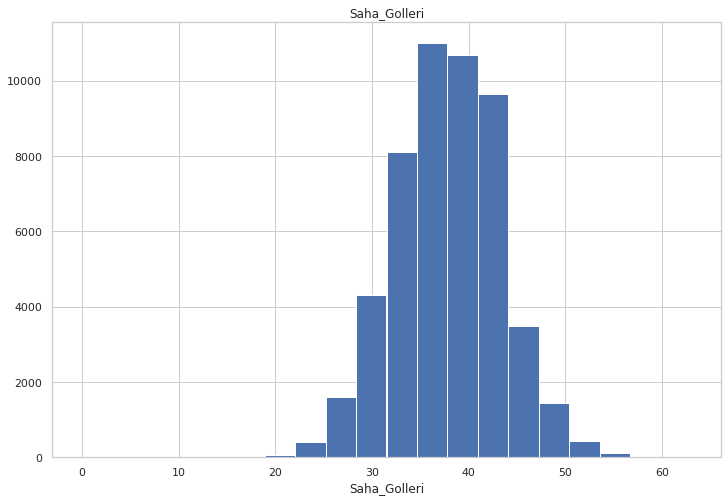

count   51337.000
mean       83.013
std         8.039
min         0.000
25%        78.000
50%        83.000
75%        88.000
max       129.000
Name: Denenen_Saha_Hedefleri, dtype: float64
#######################################


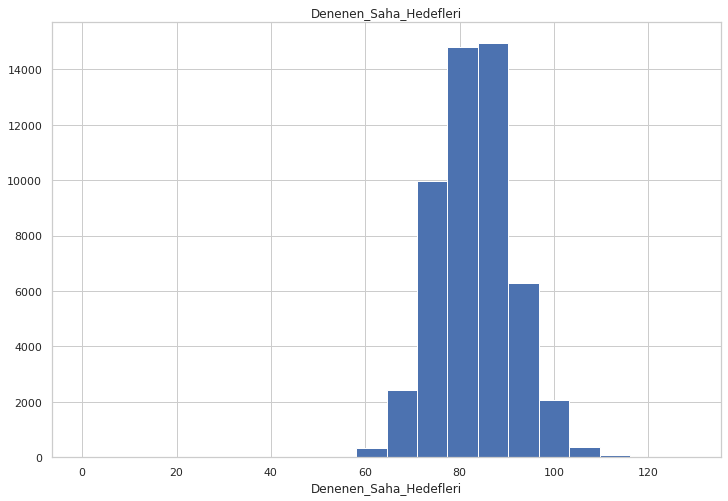

count   51337.000
mean        8.054
std         4.082
min         0.000
25%         5.000
50%         8.000
75%        11.000
max        29.000
Name: Ucluk_Yapıldı, dtype: float64
#######################################


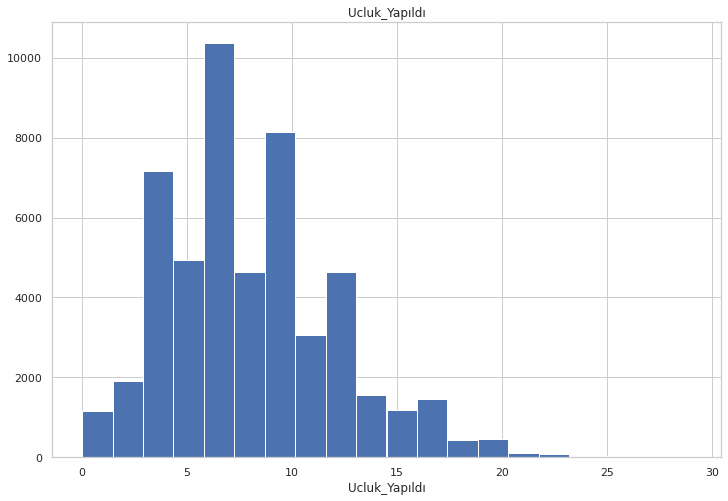

count   51337.000
mean       22.627
std         9.157
min         0.000
25%        16.000
50%        21.000
75%        29.000
max        70.000
Name: Ucluk_Denemesi, dtype: float64
#######################################


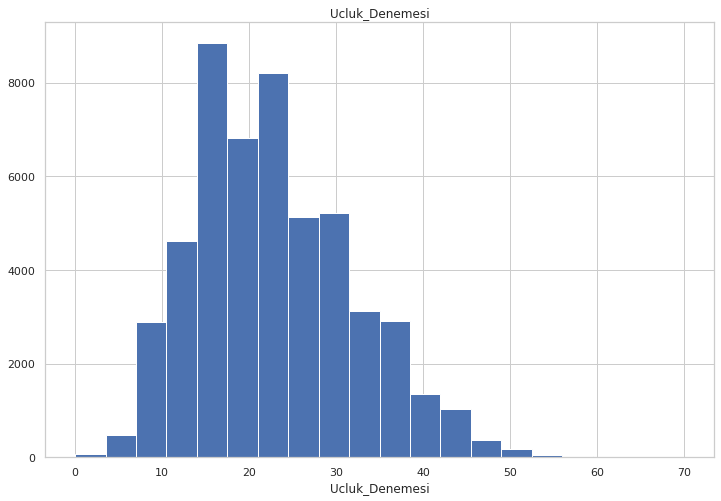

count   51337.000
mean       18.253
std         6.285
min         0.000
25%        14.000
50%        18.000
75%        22.000
max        52.000
Name: Serbest_Atış_Yapıldı, dtype: float64
#######################################


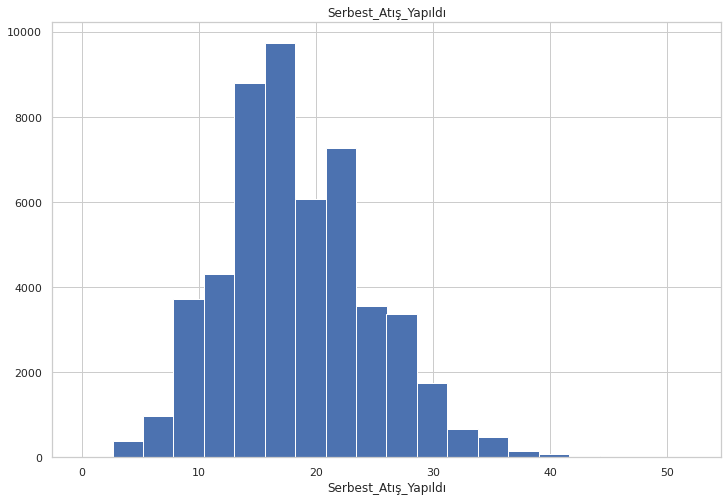

count   51337.000
mean       24.077
std         7.797
min         0.000
25%        19.000
50%        24.000
75%        29.000
max        64.000
Name: Serbest_Atış_Denendi, dtype: float64
#######################################


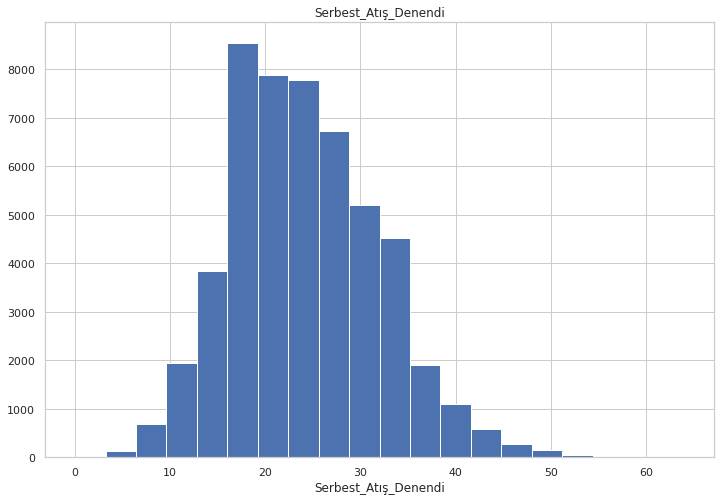

count   51337.000
mean       10.803
std         3.910
min         0.000
25%         8.000
50%        11.000
75%        13.000
max        44.000
Name: Hücum_Ribaundları, dtype: float64
#######################################


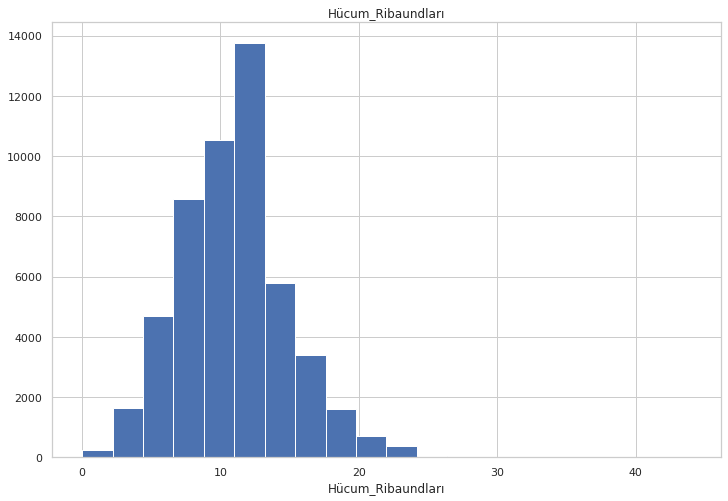

count   51337.000
mean       31.904
std         5.563
min         0.000
25%        28.000
50%        32.000
75%        36.000
max        56.000
Name: Savunma_Ribaundları, dtype: float64
#######################################


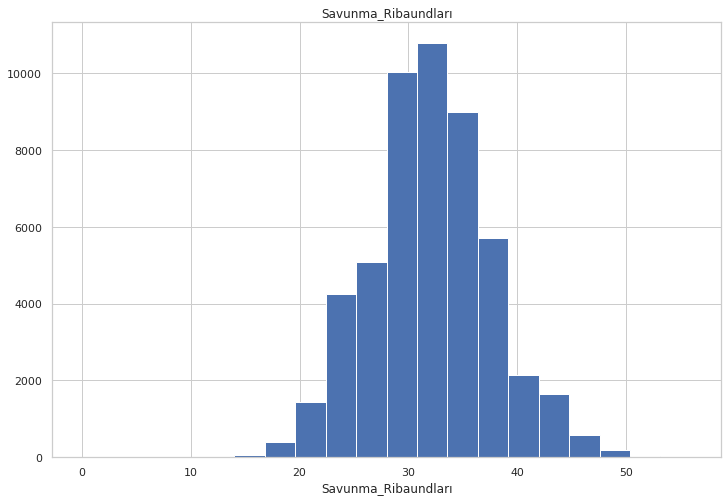

count   51337.000
mean       42.707
std         6.608
min         0.000
25%        38.000
50%        42.000
75%        47.000
max        81.000
Name: Toplam_Ribaund, dtype: float64
#######################################


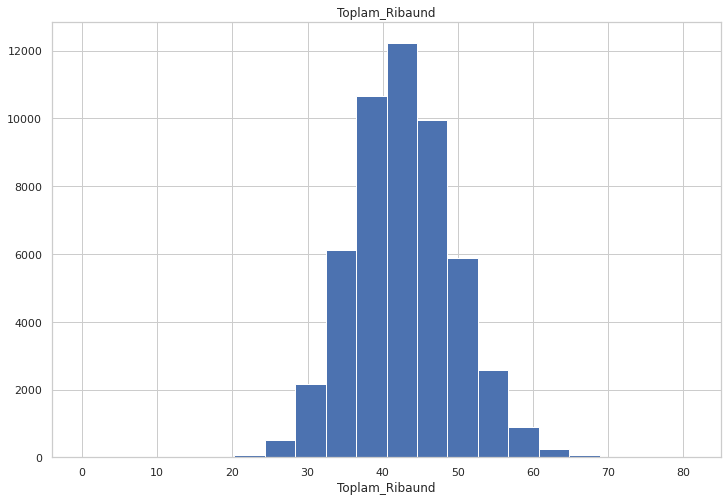

count   51336.000
mean        0.455
std         0.056
min         0.244
25%         0.417
50%         0.453
75%         0.494
max         0.687
Name: Saha_Gol_Başarı_Oranı, dtype: float64
#######################################


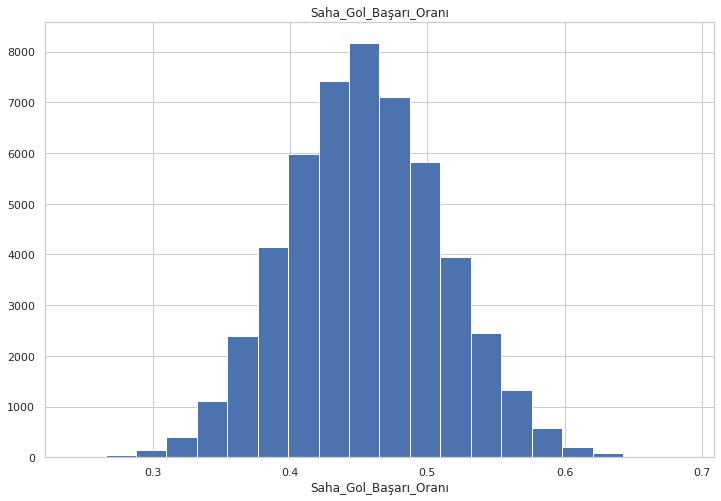

count   51336.000
mean        0.353
std         0.111
min         0.000
25%         0.281
50%         0.353
75%         0.423
max         1.000
Name: Üçlük_Başarı_Oranı, dtype: float64
#######################################


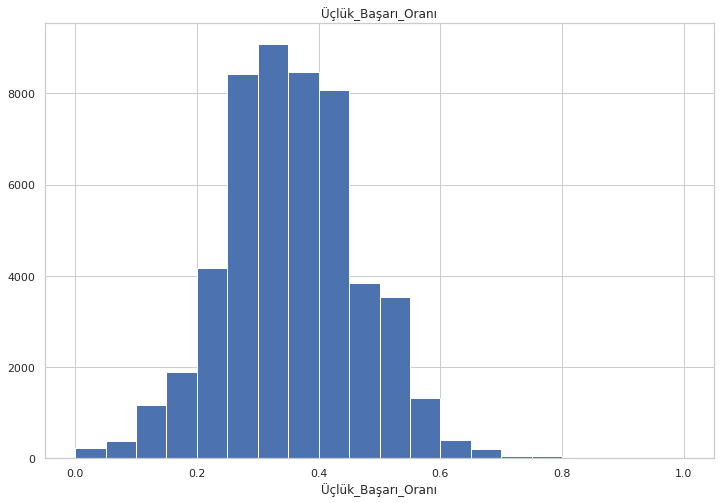

count   51336.000
mean        0.759
std         0.102
min         0.143
25%         0.696
50%         0.765
75%         0.829
max         1.000
Name: Serbest_Atış_Başarı_Oranı, dtype: float64
#######################################


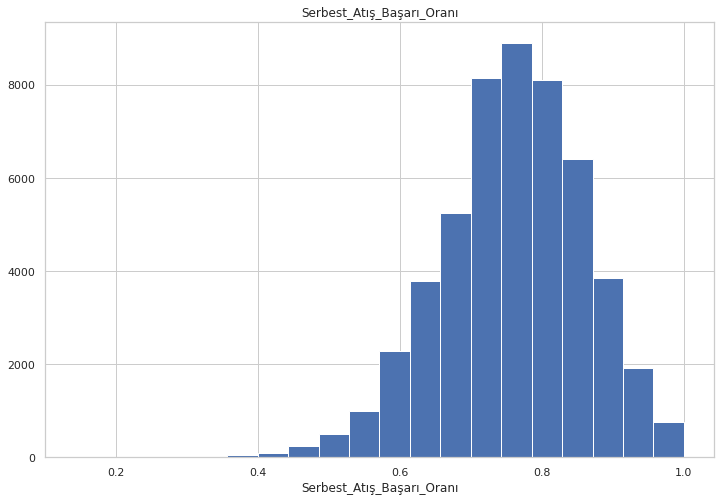

count   51336.000
mean        0.251
std         0.078
min         0.000
25%         0.196
50%         0.250
75%         0.302
max         0.936
Name: Hücum_Ribaund_Oranı, dtype: float64
#######################################


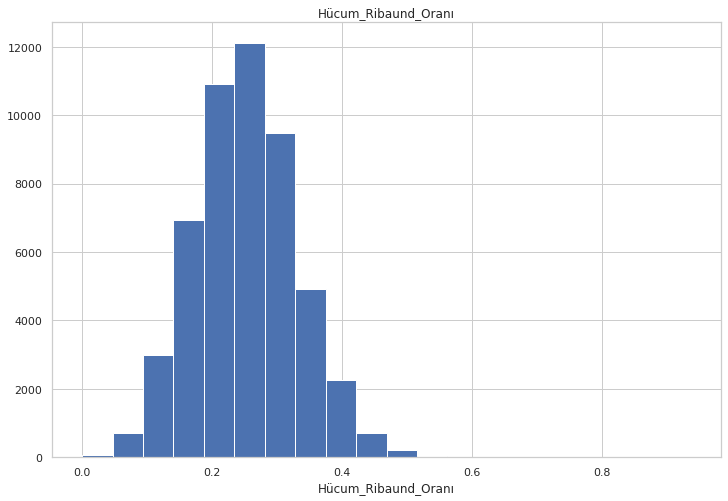

count   51336.000
mean        0.749
std         0.078
min         0.064
25%         0.698
50%         0.750
75%         0.804
max         1.000
Name: Savunma_Ribaund_Oranı, dtype: float64
#######################################


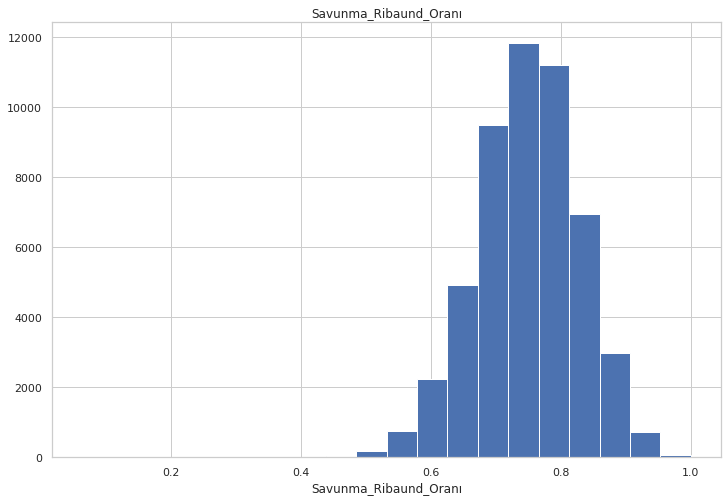

In [36]:
#Sayısal değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
    print(dataframe[numerical_col].describe())
    print("#######################################")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(oyun_veri_grup, col, plot=True)

In [37]:
# Hedef değişken "Kazanma durumu"; 1 kazandığını, 0 ise kazanamadığını belirtmektedir.

#Hedef değişken analizi yaptım.

def target_summary_with_num(dataframe, target, numarical_col):
    print(dataframe.groupby(target).agg({numarical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(oyun_veri_grup, "KAZANMA_DURUMU", col)

                Saha_Golleri
KAZANMA_DURUMU              
0                     36.859
1                     39.670


                Denenen_Saha_Hedefleri
KAZANMA_DURUMU                        
0                               83.165
1                               82.649


                Ucluk_Yapıldı
KAZANMA_DURUMU               
0                       7.795
1                       8.672


                Ucluk_Denemesi
KAZANMA_DURUMU                
0                       22.720
1                       22.405


                Serbest_Atış_Yapıldı
KAZANMA_DURUMU                      
0                             17.750
1                             19.454


                Serbest_Atış_Denendi
KAZANMA_DURUMU                      
0                             23.524
1                             25.397


                Hücum_Ribaundları
KAZANMA_DURUMU                   
0                          10.769
1                          10.884


                Savunma_Ribaundları
KA

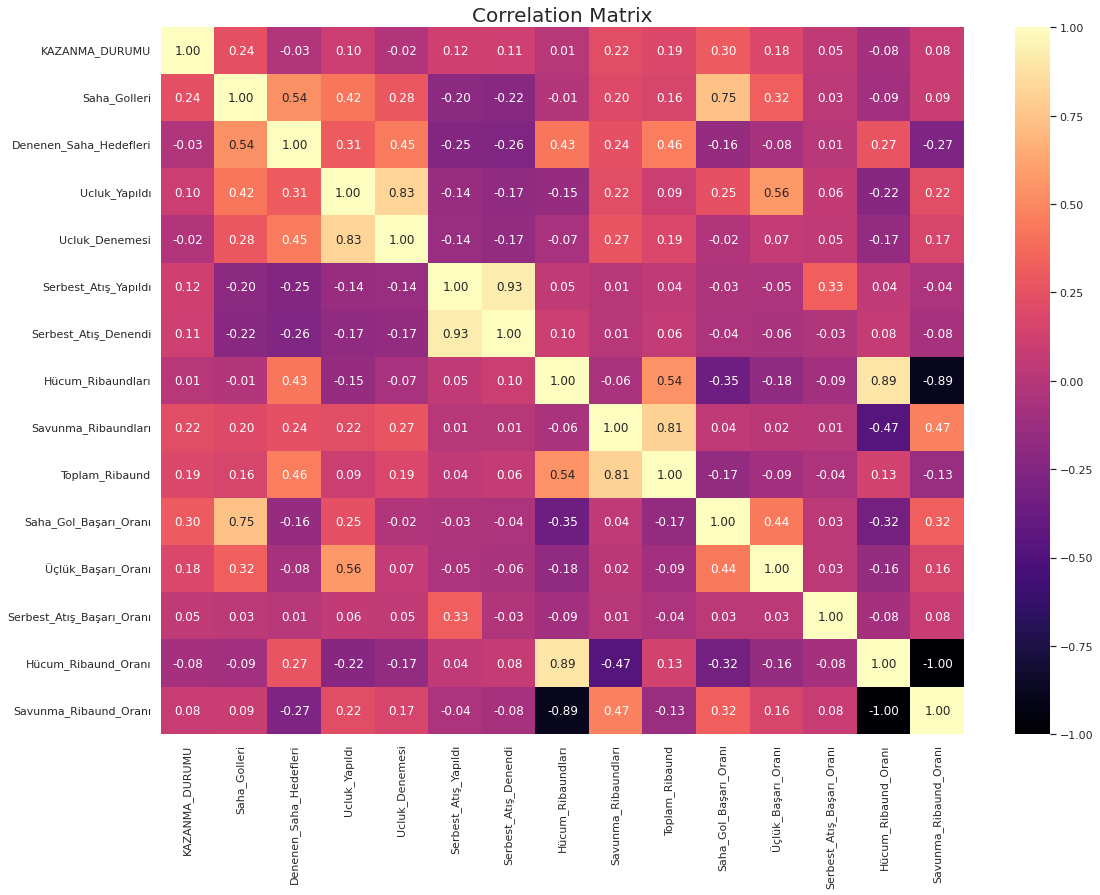

In [38]:
#Korelasyon analizi yaptım.
oyun_veri_grup.corr()
f, ax = plt.subplots(figsize=[18,13])
sns.heatmap(oyun_veri_grup.corr(), annot=True, fmt= ".2f", ax=ax, cmap= "magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [39]:
#Aykırı gözlem analizi

#Öncelikle eşik değerlere erişilmeli. Bir değişkenin çeyrek değerleri hesaplanmalı. Onun üzerinden de iqr hesaplaması yapılabilir.
#Her seferinde değişken özelinde alt limit ve üst limit belirlememek yerine işlemleri fonksiyonlaştırmak daha iyi olacaktır.

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# “Aykırı değer var mı?” sorusu için de bir fonksiyon tanımladım.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

#Bu fonksiyonda da yine daha önce tanımladığımız outlier_thresholds fonksiyonu alt ve üst limitleri hesapladı.
#Daha sonra alt limitten aşağıda olan değerleri alt limitle, üst limitten yukarıda olan ilgili değişkenleri de üst limit ile değiştirdi.
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [40]:
#AYKIRI DEĞER VAR MI?

for col in oyun_veri_grup.columns:
    print(col, check_outlier(oyun_veri_grup, col))
    if check_outlier(oyun_veri_grup, col):
        replace_with_thresholds(oyun_veri_grup,col)

KAZANMA_DURUMU False
Saha_Golleri True
Denenen_Saha_Hedefleri True
Ucluk_Yapıldı False
Ucluk_Denemesi False
Serbest_Atış_Yapıldı False
Serbest_Atış_Denendi False
Hücum_Ribaundları True
Savunma_Ribaundları False
Toplam_Ribaund False
Saha_Gol_Başarı_Oranı False
Üçlük_Başarı_Oranı False
Serbest_Atış_Başarı_Oranı False
Hücum_Ribaund_Oranı True
Savunma_Ribaund_Oranı True


In [41]:
#BASKILAMA İŞLEMİ

for col in oyun_veri_grup.columns:
    print(col, check_outlier(oyun_veri_grup,col))

KAZANMA_DURUMU False
Saha_Golleri False
Denenen_Saha_Hedefleri False
Ucluk_Yapıldı False
Ucluk_Denemesi False
Serbest_Atış_Yapıldı False
Serbest_Atış_Denendi False
Hücum_Ribaundları False
Savunma_Ribaundları False
Toplam_Ribaund False
Saha_Gol_Başarı_Oranı False
Üçlük_Başarı_Oranı False
Serbest_Atış_Başarı_Oranı False
Hücum_Ribaund_Oranı False
Savunma_Ribaund_Oranı False


In [42]:
#ENCODING

#LABEL ENCODİNG

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in oyun_veri_grup.columns if oyun_veri_grup[col].dtypes == "O" and oyun_veri_grup[col].nunique() == 2]

for col in binary_cols:
    oyun_veri_grup = label_encoder(oyun_veri_grup, col)

#One-Hot Encoding İşlemi
#cat_cols listesinin güncelleme işlemi

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["KAZANMA_DURUMU"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

oyun_veri_grup = one_hot_encoder(oyun_veri_grup, cat_cols, drop_first=True)

oyun_veri_grup.head()

KAZANMA_DURUMU  Saha_Golleri  \
MAC_ID   TAKIM                                           
10300001 Deplasman Takım               0            34   
         Ev Sahibi Takım               1            32   
10300002 Deplasman Takım               0            32   
         Ev Sahibi Takım               1            40   
10300003 Deplasman Takım               0            38   

                          Denenen_Saha_Hedefleri  Ucluk_Yapıldı  \
MAC_ID   TAKIM                                                    
10300001 Deplasman Takım                      76              2   
         Ev Sahibi Takım                      70              1   
10300002 Deplasman Takım                      75              2   
         Ev Sahibi Takım                      81              4   
10300003 Deplasman Takım                      77              4   

                          Ucluk_Denemesi  Serbest_Atış_Yapıldı  \
MAC_ID   TAKIM                                                   
10300001 Deplasman Takım               8                    15   
         Ev Sahibi Takım               7                    25   
10300002 Deplasman Takım              13                    28   
         Ev Sahibi Takım              15                    21   
10300003 Deplasman Takım               6                    20   

                          Serbest_Atış_Denendi  Hücum_Ribaundları  \
MAC_ID   TAKIM                                                      
10300001 Deplasman Takım                    30             12.000   
         Ev Sahibi Takım                    34              9.000   
10300002 Deplasman Takım                    40             11.000   
         Ev Sahibi Takım                    34             14.000   
10300003 Deplasman Takım                    29             12.000   

                          Savunma_Ribaundları  Toplam_Ribaund  \
MAC_ID   TAKIM                                                  
10300001 Deplasman Takım                   26              38   
         Ev Sahibi Takım                   32              41   
10300002 Deplasman Takım                   32              43   
         Ev Sahibi Takım                   34              48   
10300003 Deplasman Takım                   40              52   

                          Saha_Gol_Başarı_Oranı  Üçlük_Başarı_Oranı  \
MAC_ID   TAKIM                                                        
10300001 Deplasman Takım                  0.447               0.250   
         Ev Sahibi Takım                  0.457               0.143   
10300002 Deplasman Takım                  0.427               0.154   
         Ev Sahibi Takım                  0.494               0.267   
10300003 Deplasman Takım                  0.494               0.667   

                          Serbest_Atış_Başarı_Oranı  Hücum_Ribaund_Oranı  \
MAC_ID   TAKIM                                                             
10300001 Deplasman Takım                      0.500                0.316   
         Ev Sahibi Takım                      0.735                0.220   
10300002 Deplasman Takım                      0.700                0.256   
         Ev Sahibi Takım                      0.618                0.292   
10300003 Deplasman Takım                      0.690                0.231   

                          Savunma_Ribaund_Oranı  
MAC_ID   TAKIM                                   
10300001 Deplasman Takım                  0.684  
         Ev Sahibi Takım                  0.780  
10300002 Deplasman Takım                  0.744  
         Ev Sahibi Takım                  0.708  
10300003 Deplasman Takım                  0.769

In [43]:
#STANDARTLAŞTIRMA

scaler = StandardScaler()
oyun_veri_grup[num_cols] =scaler.fit_transform(oyun_veri_grup[num_cols])

oyun_veri_grup.head()


KAZANMA_DURUMU  Saha_Golleri  \
MAC_ID   TAKIM                                           
10300001 Deplasman Takım               0        -0.678   
         Ev Sahibi Takım               1        -1.046   
10300002 Deplasman Takım               0        -1.046   
         Ev Sahibi Takım               1         0.425   
10300003 Deplasman Takım               0         0.057   

                          Denenen_Saha_Hedefleri  Ucluk_Yapıldı  \
MAC_ID   TAKIM                                                    
10300001 Deplasman Takım                  -0.873         -1.483   
         Ev Sahibi Takım                  -1.620         -1.728   
10300002 Deplasman Takım                  -0.997         -1.483   
         Ev Sahibi Takım                  -0.251         -0.993   
10300003 Deplasman Takım                  -0.749         -0.993   

                          Ucluk_Denemesi  Serbest_Atış_Yapıldı  \
MAC_ID   TAKIM                                                   
10300001 Deplasman Takım          -1.597                -0.518   
         Ev Sahibi Takım          -1.707                 1.074   
10300002 Deplasman Takım          -1.051                 1.551   
         Ev Sahibi Takım          -0.833                 0.437   
10300003 Deplasman Takım          -1.816                 0.278   

                          Serbest_Atış_Denendi  Hücum_Ribaundları  \
MAC_ID   TAKIM                                                      
10300001 Deplasman Takım                 0.760              0.306   
         Ev Sahibi Takım                 1.273             -0.461   
10300002 Deplasman Takım                 2.042              0.050   
         Ev Sahibi Takım                 1.273              0.818   
10300003 Deplasman Takım                 0.631              0.306   

                          Savunma_Ribaundları  Toplam_Ribaund  \
MAC_ID   TAKIM                                                  
10300001 Deplasman Takım               -1.061          -0.712   
         Ev Sahibi Takım                0.017          -0.258   
10300002 Deplasman Takım                0.017           0.044   
         Ev Sahibi Takım                0.377           0.801   
10300003 Deplasman Takım                1.455           1.406   

                          Saha_Gol_Başarı_Oranı  Üçlük_Başarı_Oranı  \
MAC_ID   TAKIM                                                        
10300001 Deplasman Takım                 -0.133              -0.926   
         Ev Sahibi Takım                  0.041              -1.889   
10300002 Deplasman Takım                 -0.500              -1.791   
         Ev Sahibi Takım                  0.692              -0.776   
10300003 Deplasman Takım                  0.687               2.823   

                          Serbest_Atış_Başarı_Oranı  Hücum_Ribaund_Oranı  \
MAC_ID   TAKIM                                                             
10300001 Deplasman Takım                     -2.545                0.831   
         Ev Sahibi Takım                     -0.233               -0.410   
10300002 Deplasman Takım                     -0.580                0.058   
         Ev Sahibi Takım                     -1.389                0.520   
10300003 Deplasman Takım                     -0.681               -0.265   

                          Savunma_Ribaund_Oranı  
MAC_ID   TAKIM                                   
10300001 Deplasman Takım                 -0.831  
         Ev Sahibi Takım                  0.410  
10300002 Deplasman Takım                 -0.058  
         Ev Sahibi Takım                 -0.520  
10300003 Deplasman Takım                  0.265

In [44]:
#Eksik değerleri yok ettim. 
oyun_veri_grup.dropna(inplace=True)


In [45]:
#MODELLEME

y = oyun_veri_grup["KAZANMA_DURUMU"]
X = oyun_veri_grup.drop("KAZANMA_DURUMU", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test),2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.73
Recall: 0.553
Precision: 0.35
F1: 0.42
Auc: 0.66


**BAŞARI ORANI: 0.73**

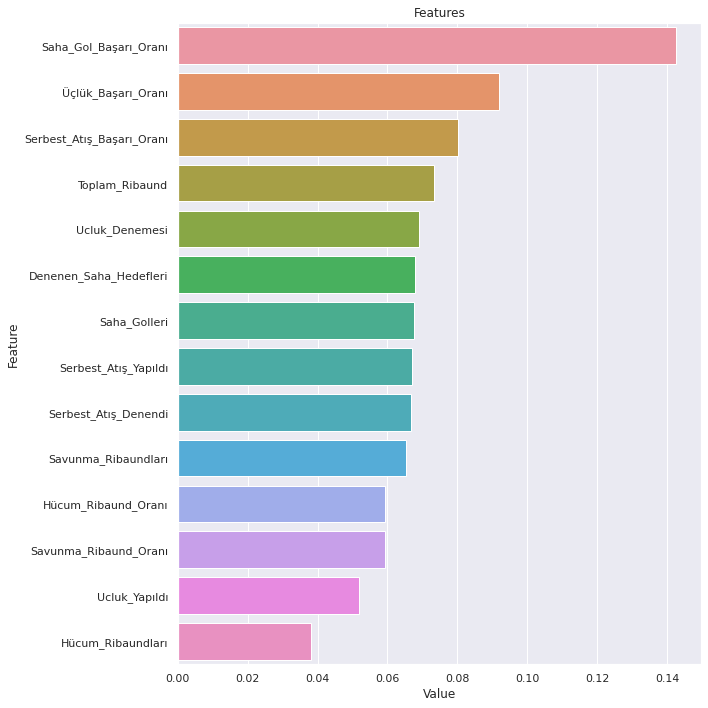

In [47]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data= feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

plot_importance(rf_model, X)